In [1]:
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
today = pd.Timestamp(datetime.datetime.now())
today = today.strftime('%m-%d-%y')
print(f'Today is {today}')


Today is 03-15-23


In [2]:
def convert_scale(value):
    if value.endswith('M'):
        return float(value[:-1]) * 10**6
    elif value.endswith('B'):
        return float(value[:-1]) * 10**9
    elif value.endswith('T'):
        return float(value[:-1]) * 10**12
    else:
        return float(value)


In [3]:
# unit test

'''def test_convert_scale_string():
    scale = convert_scale('test')
    print(scale)
    assert scale == 0
    '''
def test_convert_scale_negative():
    scale = convert_scale('-5')
    print(scale)
    assert scale == -5.0

'''def test_convert_scale_M():
    scale = convert_scale('K')
    print(scale)
    assert scale == 0'''

def test_convert_scale_M():
    scale = convert_scale('5M')
    print(scale)
    assert scale == 5000000

In [4]:
#test_convert_scale_string()
test_convert_scale_negative()
test_convert_scale_M()


-5.0
5000000.0


In [58]:
# reading in from a website
most_active = pd.read_html('https://finance.yahoo.com/most-active')[0]
print(most_active.shape)
most_active.head()


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,CS,Credit Suisse Group AG,2.16,-0.35,-13.94%,422.265M,29.199M,9.671B,NaN,NaN
1,TSLA,"Tesla, Inc.",180.45,-2.81,-1.53%,145.996M,184.604M,579.564B,47.86,NaN
2,BAC,Bank of America Corporation,28.49,-0.27,-0.94%,130.95M,45.96M,227.899B,8.85,NaN
3,F,Ford Motor Company,11.71,-0.22,-1.84%,107.025M,65.232M,47.555B,NaN,NaN
4,FRC,First Republic Bank,31.16,-8.47,-21.37%,95.937M,8.409M,5.803B,2.98,NaN


In [59]:
gainers = pd.read_html('https://finance.yahoo.com/gainers')[0]
print(gainers.shape)
gainers.head()


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,SMAR,Smartsheet Inc.,45.13,6.81,+17.77%,6.394M,1.37M,5.927B,NaN,NaN
1,WAL,Western Alliance Bancorporation,32.35,2.48,+8.30%,32.352M,3.775M,3.546B,6.97,NaN
2,ROIV,Roivant Sciences Ltd.,8.59,0.63,+7.91%,6.789M,2.401M,6.515B,NaN,NaN
3,NYCB,"New York Community Bancorp, Inc.",6.96,0.49,+7.57%,49.583M,10.813M,4.753B,5.48,NaN
4,S,"SentinelOne, Inc.",15.54,1.07,+7.39%,15.124M,5.353M,4.393B,NaN,NaN


In [60]:
losers = pd.read_html('https://finance.yahoo.com/losers')[0]
print(losers.shape)
losers.head()


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,FRC,First Republic Bank,31.16,-8.47,-21.37%,95.937M,8.409M,5.803B,2.98,NaN
1,FRC-PH,First Republic Bank,9.95,-2.37,-19.24%,617834,52304,6.409B,1.26,NaN
2,CSGKF,Credit Suisse Group AG,2.07,-0.34,-14.11%,3.587M,452776,9.671B,NaN,NaN
3,CS,Credit Suisse Group AG,2.16,-0.35,-13.94%,422.265M,29.199M,9.671B,NaN,NaN
4,APE,"AMC Entertainment Holdings, Inc.",1.42,-0.22,-13.41%,42.192M,34.941M,4.018B,NaN,NaN


In [61]:
stocks_df = pd.concat([most_active, gainers, losers])
print(stocks_df.shape)
print(f'Datatype before the change \n {stocks_df.info()}')
stocks_df.head()
#concat['% Change'] = 
#concat['% Change'].replace({'%' : ''}, regex=True)



(75, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 24
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Symbol             75 non-null     object 
 1   Name               75 non-null     object 
 2   Price (Intraday)   75 non-null     float64
 3   Change             75 non-null     float64
 4   % Change           75 non-null     object 
 5   Volume             75 non-null     object 
 6   Avg Vol (3 month)  75 non-null     object 
 7   Market Cap         75 non-null     object 
 8   PE Ratio (TTM)     49 non-null     float64
 9   52 Week Range      0 non-null      float64
dtypes: float64(4), object(6)
memory usage: 6.4+ KB
Datatype before the change 
 None


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,CS,Credit Suisse Group AG,2.16,-0.35,-13.94%,422.265M,29.199M,9.671B,NaN,NaN
1,TSLA,"Tesla, Inc.",180.45,-2.81,-1.53%,145.996M,184.604M,579.564B,47.86,NaN
2,BAC,Bank of America Corporation,28.49,-0.27,-0.94%,130.95M,45.96M,227.899B,8.85,NaN
3,F,Ford Motor Company,11.71,-0.22,-1.84%,107.025M,65.232M,47.555B,NaN,NaN
4,FRC,First Republic Bank,31.16,-8.47,-21.37%,95.937M,8.409M,5.803B,2.98,NaN


In [62]:
stocks_df['PE Ratio (TTM)'] = stocks_df['PE Ratio (TTM)'].fillna(0)
stocks_df.dropna(axis=1, thresh=9, inplace=True)
#losers.set_index('Symbol',inplace=True)
#stocks_df.head()
#losers.info()
stocks_df['Volume'] = stocks_df['Volume'].apply(convert_scale)
stocks_df['Avg Vol (3 month)'] = stocks_df['Avg Vol (3 month)'].apply(convert_scale)
stocks_df['Market Cap'] = stocks_df['Market Cap'].apply(convert_scale)
stocks_df['% Change'] = pd.to_numeric(stocks_df['% Change'].replace({'%' : ''}, regex=True))

print(f'Datatypes after the change: {stocks_df.info()}')
stocks_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 24
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Symbol             75 non-null     object 
 1   Name               75 non-null     object 
 2   Price (Intraday)   75 non-null     float64
 3   Change             75 non-null     float64
 4   % Change           75 non-null     float64
 5   Volume             75 non-null     float64
 6   Avg Vol (3 month)  75 non-null     float64
 7   Market Cap         75 non-null     float64
 8   PE Ratio (TTM)     75 non-null     float64
dtypes: float64(7), object(2)
memory usage: 5.9+ KB
Datatypes after the change: None


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
0,CS,Credit Suisse Group AG,2.16,-0.35,-13.94,422265000.0,29199000.0,9.671000e+09,0.00
1,TSLA,"Tesla, Inc.",180.45,-2.81,-1.53,145996000.0,184604000.0,5.795640e+11,47.86
2,BAC,Bank of America Corporation,28.49,-0.27,-0.94,130950000.0,45960000.0,2.278990e+11,8.85
3,F,Ford Motor Company,11.71,-0.22,-1.84,107025000.0,65232000.0,4.755500e+10,0.00
4,FRC,First Republic Bank,31.16,-8.47,-21.37,95937000.0,8409000.0,5.803000e+09,2.98
...,...,...,...,...,...,...,...,...,...
20,KOS,Kosmos Energy Ltd.,6.21,-0.66,-9.61,8046000.0,6191000.0,2.854000e+09,13.50
21,UNCFF,UniCredit S.p.A.,16.96,-1.76,-9.40,27194.0,6579.0,3.499500e+10,6.06
22,SLG-PI,SL Green Realty Corp.,17.65,-1.83,-9.39,74171.0,22008.0,5.125000e+09,2.61
23,AMR,"Alpha Metallurgical Resources, Inc.",147.54,-15.23,-9.36,486933.0,238772.0,2.238000e+09,1.83


In [19]:
# find if there are any duplicated rows
duplicate = stocks_df[stocks_df.duplicated()]
duplicate

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
3,NYCB,"New York Community Bancorp, Inc.",6.96,0.49,7.57,49583000.0,10813000.0,4.753000e+09,5.48
12,SCHW,The Charles Schwab Corporation,59.55,2.87,5.06,86538000.0,15231000.0,1.089120e+11,15.59
0,FRC,First Republic Bank,31.16,-8.47,-21.37,95937000.0,8409000.0,5.803000e+09,2.98
3,CS,Credit Suisse Group AG,2.16,-0.35,-13.94,422265000.0,29199000.0,9.671000e+09,0.00
4,APE,"AMC Entertainment Holdings, Inc.",1.42,-0.22,-13.41,42192000.0,34941000.0,4.018000e+09,0.00


In [20]:
stocks_df.drop_duplicates(keep='first', inplace=True)
stocks_df.shape

(70, 9)

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >], dtype=object)

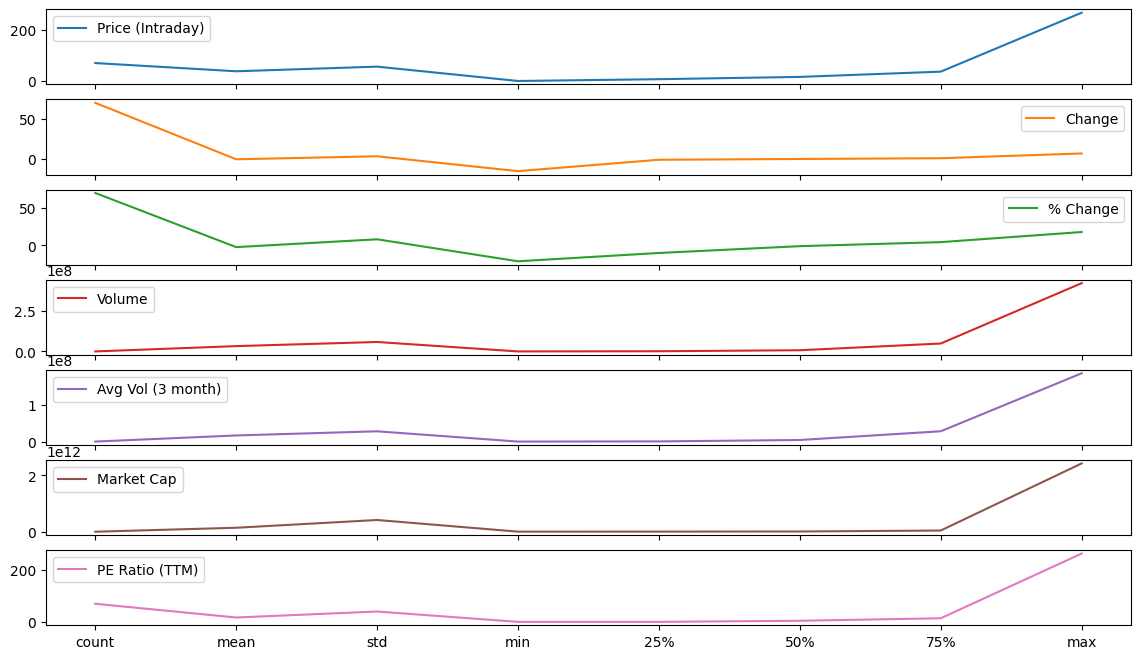

In [28]:

stocks_df.describe().plot(subplots=True, figsize=(14,8))

In [63]:
# find all rows that have 'Corp' in its name?
stocks_df.loc[stocks_df.Name.str.contains('(?i)Bank', regex=True)]

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
2,BAC,Bank of America Corporation,28.49,-0.27,-0.94,130950000.0,45960000.0,2.278990e+11,8.85
4,FRC,First Republic Bank,31.16,-8.47,-21.37,95937000.0,8409000.0,5.803000e+09,2.98
0,FRC,First Republic Bank,31.16,-8.47,-21.37,95937000.0,8409000.0,5.803000e+09,2.98
1,FRC-PH,First Republic Bank,9.95,-2.37,-19.24,617834.0,52304.0,6.409000e+09,1.26
5,FRC-PI,First Republic Bank,11.27,-1.72,-13.24,441313.0,64351.0,7.105000e+09,1.43


In [30]:
volume_change = stocks_df.query('Volume >= 20000000 and Change <= -5')
volume_change

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
4,FRC,First Republic Bank,31.16,-8.47,-21.37,95937000.0,8409000.0,5.803000e+09,2.98


In [31]:
stocks_df.query('`% Change` < -50')[['Name', '% Change']]

,Name,% Change


In [32]:

Symbol_s = stocks_df.loc[(stocks_df['PE Ratio (TTM)']>=19) & (stocks_df['Change']<= -5) & (stocks_df['Symbol'].str.startswith('S')),['Symbol', 'Name']]
Symbol_s

,Symbol,Name


In order to filter a DataFrame column that has spaces with the query method, we wrap the column using backticks. While this may not look great, it does allow us to use any column in the method.

In [35]:
large_market_cap = stocks_df.query("`Market Cap` > 200000000000")
large_market_cap.head()



,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
1,TSLA,"Tesla, Inc.",180.45,-2.81,-1.53,145996000.0,184604000.0,5.795640e+11,47.86
2,BAC,Bank of America Corporation,28.49,-0.27,-0.94,130950000.0,45960000.0,2.278990e+11,8.85
9,AAPL,Apple Inc.,152.99,0.40,0.26,77168000.0,70671000.0,2.421000e+12,25.63
11,AMZN,"Amazon.com, Inc.",96.20,1.32,1.39,70732000.0,69769000.0,9.857900e+11,0.00
13,NVDA,NVIDIA Corporation,242.28,1.65,0.69,52449000.0,48220000.0,6.037620e+11,103.10


In [52]:
top_5_company = stocks_df.nlargest(5,['Volume'])
top_5_company


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
0,CS,Credit Suisse Group AG,2.16,-0.35,-13.94,422265000.0,29199000.0,9.671000e+09,0.00
1,TSLA,"Tesla, Inc.",180.45,-2.81,-1.53,145996000.0,184604000.0,5.795640e+11,47.86
2,BAC,Bank of America Corporation,28.49,-0.27,-0.94,130950000.0,45960000.0,2.278990e+11,8.85
3,F,Ford Motor Company,11.71,-0.22,-1.84,107025000.0,65232000.0,4.755500e+10,0.00
4,FRC,First Republic Bank,31.16,-8.47,-21.37,95937000.0,8409000.0,5.803000e+09,2.98


In [53]:
top_5_volume = (top_5_company.Symbol).to_list()
top_5_volume

['CS', 'TSLA', 'BAC', 'F', 'FRC']

In [54]:
ticker = yf.download(top_5_volume, period='1y',interval='1d', ignore_tz=True, progress=False, auto_adjust=False, actions='inline' )
ticker.info()
ticker.head()
#ticker.to_csv('ticker.csv')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-03-16 to 2023-03-15
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, BAC)      251 non-null    float64
 1   (Adj Close, CS)       251 non-null    float64
 2   (Adj Close, F)        251 non-null    float64
 3   (Adj Close, FRC)      251 non-null    float64
 4   (Adj Close, TSLA)     251 non-null    float64
 5   (Close, BAC)          251 non-null    float64
 6   (Close, CS)           251 non-null    float64
 7   (Close, F)            251 non-null    float64
 8   (Close, FRC)          251 non-null    float64
 9   (Close, TSLA)         251 non-null    float64
 10  (Dividends, BAC)      251 non-null    float64
 11  (Dividends, CS)       251 non-null    float64
 12  (Dividends, F)        251 non-null    float64
 13  (Dividends, FRC)      251 non-null    float64
 14  (Dividends, TSLA)     251 non-null    float64
 15  (Hig

Adj Close                                                   Close  \
                  BAC        CS          F         FRC        TSLA        BAC   
Date                                                                            
2022-03-16  41.759769  7.853372  15.181973  168.062866  280.076660  42.799999   
2022-03-17  41.984177  7.882895  15.181973  167.616348  290.533325  43.029999   
2022-03-18  41.857342  8.020674  15.438365  169.184082  301.796661  42.900002   
2022-03-21  41.798801  8.010833  15.090405  166.524918  307.053345  42.840000   
2022-03-22  43.106228  8.119087  15.648971  169.203934  331.326660  44.180000   

                                                     ... Stock Splits       \
              CS          F         FRC        TSLA  ...          BAC   CS   
Date                                                 ...                     
2022-03-16  7.98  16.580000  169.380005  280.076660  ...          0.0  0.0   
2022-03-17  8.01  16.580000  168.929993  290.533325  ...          0.0  0.0   
2022-03-18  8.15  16.860001  170.509995  301.796661  ...          0.0  0.0   
2022-03-21  8.14  16.480000  167.830002  307.053345  ...          0.0  0.0   
2022-03-22  8.25  17.090000  170.529999  331.326660  ...          0.0  0.0   

                             Volume                                          
              F  FRC TSLA       BAC        CS         F      FRC       TSLA  
Date                                                                         
2022-03-16  0.0  0.0  0.0  59477600  16580100  82677600  2055000   84028800  
2022-03-17  0.0  0.0  0.0  50260200   9859300  58500200   884900   66582900  
2022-03-18  0.0  0.0  0.0  74470600   9640200  89144000  1494300  100414200  
2022-03-21  0.0  0.0  0.0  47106400  11540600  72583600   639700   81981600  
2022-03-22  0.0  0.0  0.0  52360600   8832500  77647100  1557500  105868500  

[5 rows x 40 columns]

In [55]:
'''high_close = ticker[ticker[('Close', 'AAPL')] >= ticker[('High', 'AMZN')]]
high_close'''


"high_close = ticker[ticker[('Close', 'AAPL')] >= ticker[('High', 'AMZN')]]\nhigh_close"

In [56]:
close = ticker.Close
close.info()
close.head()
close.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-03-16 to 2023-03-15
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BAC     251 non-null    float64
 1   CS      251 non-null    float64
 2   F       251 non-null    float64
 3   FRC     251 non-null    float64
 4   TSLA    251 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB


,BAC,CS,F,FRC,TSLA
count,251.000000,251.000000,251.000000,251.000000,251.000000
mean,34.933187,5.021633,13.514143,139.372550,235.926627
std,2.970260,1.581843,1.573178,20.663790,62.720394
min,28.490000,2.160000,10.950000,31.160000,108.099998
25%,33.000000,3.510000,12.230000,123.799999,192.555000
50%,34.509998,5.120000,13.220000,141.009995,233.070007
75%,36.389999,5.945000,14.730000,155.040001,288.569992
max,44.180000,8.250000,17.750000,170.529999,381.816681


In [57]:
fig = px.line(close, title=f"Top 5 Companies with largest volume on {today} for last 3y") 
fig.show()

                BAC            CS             F           FRC          TSLA
count  2.510000e+02  2.510000e+02  2.510000e+02  2.510000e+02  2.510000e+02
mean   4.479688e+07  1.969712e+07  6.336075e+07  2.968938e+06  1.076530e+08
std    2.131036e+07  2.778425e+07  2.184600e+07  1.310299e+07  4.971621e+07
min    1.611850e+07  6.607100e+06  1.298090e+07  4.135000e+05  4.186470e+07
25%    3.317660e+07  1.183930e+07  5.049385e+07  8.750500e+05  7.128240e+07
50%    4.036020e+07  1.563550e+07  5.867670e+07  1.214500e+06  9.148300e+07
75%    4.938440e+07  2.028815e+07  7.318755e+07  1.591250e+06  1.389452e+08
max    2.184033e+08  4.317424e+08  1.963400e+08  1.349395e+08  3.065906e+08


array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>], dtype=object)

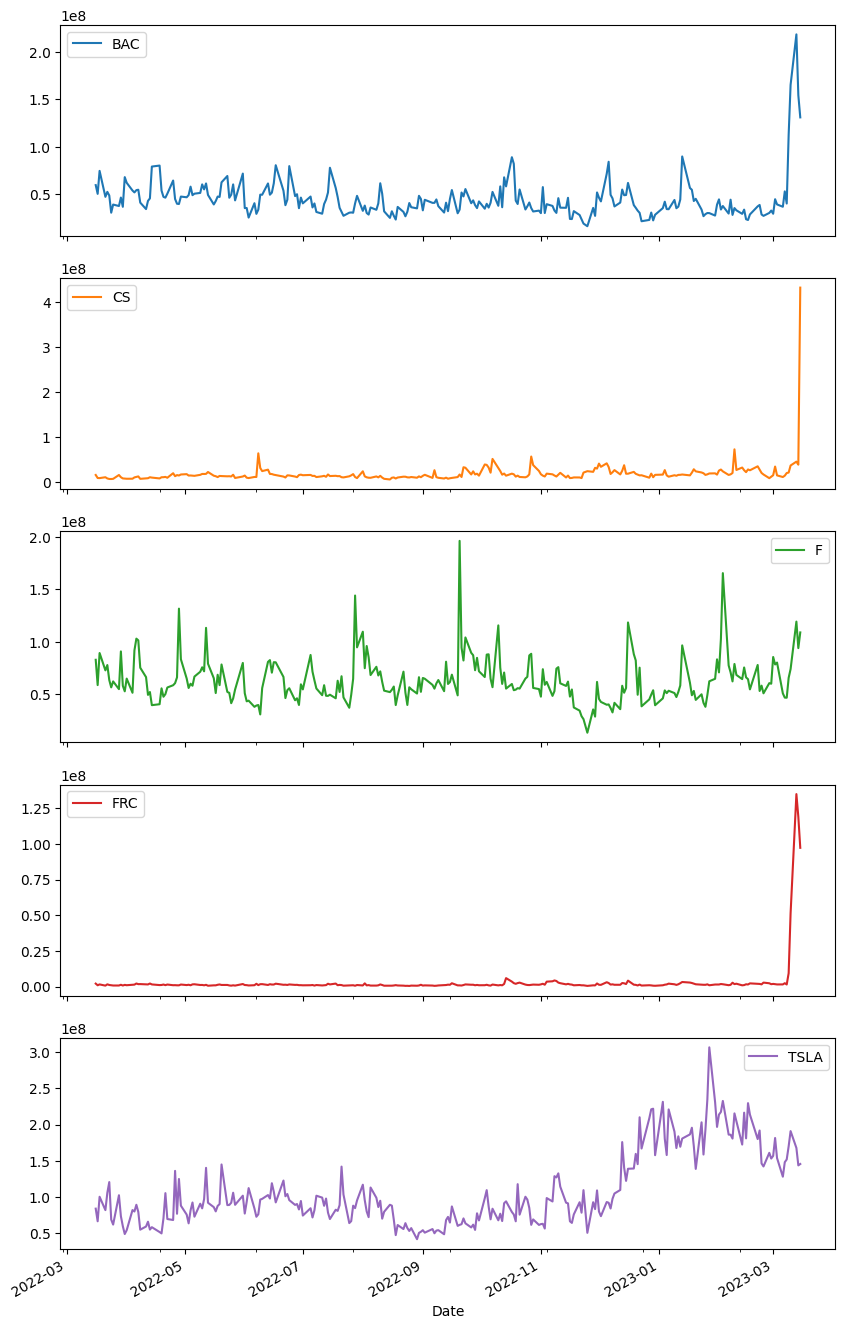

In [41]:
volume = ticker.Volume
volume

print(volume.describe())
volume.plot(subplots=True, figsize=(10,18))


In [42]:
high = ticker.High
high.to_csv('high.csv')
figure = px.bar(high)
figure.show()

In [43]:
low = ticker.Low.to_csv('low.csv')
figure = px.line(ticker.Low)
figure.show()

In [44]:
high1 = px.box(ticker.High)
high1.show()
high.describe()

,BAC,CS,F,FRC,TSLA
count,251.000000,251.000000,251.000000,251.000000,251.000000
mean,35.376653,5.104980,13.740637,141.525817,242.181633
std,2.984206,1.596492,1.592473,19.941167,63.899288
min,28.559999,2.230000,11.210000,37.849998,111.750000
25%,33.470001,3.540000,12.430000,126.660000,196.275002
50%,34.869999,5.210000,13.510000,143.149994,239.556671
75%,36.929998,6.050000,14.995000,156.684998,296.699997
max,44.630001,8.350000,17.799999,174.210007,384.290009


In [45]:

dividend = ticker.Dividends
dividend



,BAC,CS,F,FRC,TSLA
Date,,,,,
2022-03-16,0.0,0.0,0.0,0.0,0.0
2022-03-17,0.0,0.0,0.0,0.0,0.0
2022-03-18,0.0,0.0,0.0,0.0,0.0
2022-03-21,0.0,0.0,0.0,0.0,0.0
2022-03-22,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2023-03-09,0.0,0.0,0.0,0.0,0.0
2023-03-10,0.0,0.0,0.0,0.0,0.0
2023-03-13,0.0,0.0,0.0,0.0,0.0


In [46]:
High_Low = ticker.loc[:, ['High', 'Low' ]]
High_Low.head()
High_Low.max()
#High_Low.plot(subplots=True, figsize=(10,10))
#ax = High_Low.unstack(level=0).plot(figsize=(14,6))

High  BAC      44.630001
      CS        8.350000
      F        17.799999
      FRC     174.210007
      TSLA    384.290009
Low   BAC      43.700001
      CS        8.230000
      F        17.200001
      FRC     168.570007
      TSLA    362.433319
dtype: float64